In [1]:
from adversarylab.core.noise_generators import AdditiveNoiseGenerator
from adversarylab.attacks.whitebox import TargetedWhiteBoxAttack, NonTargetedWhiteBoxAttack
from adversarylab.core.preprocessing import PreprocessingFromFunction
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image

from adversarylab.core.tensor_ops import TensorOps

In [2]:
model = InceptionV3(weights='imagenet')

def preprocess(x, input):
    input = tf.cast(input, dtype=tf.float32)
    if len(input.shape) == 2:
        input = tf.expand_dims(input, axis=-1)
        input = tf.image.grayscale_to_rgb(input)

    elif len(input.shape) == 3 and input.shape[-1] == 1:
        input = tf.image.grayscale_to_rgb(input)

    input_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
    resized_image = tf.image.resize(input_tensor, (299, 299))
    batch_image = tf.expand_dims(resized_image, axis=0)
    return preprocess_input(batch_image)

    
pp = PreprocessingFromFunction.create(preprocess)

In [6]:
image = Image.open('assets/panda.jpg')
image_array = np.array(image)

np.argmax(model.predict(pp.preprocess(image_array)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([388], dtype=int64)

In [4]:
attacker = TargetedWhiteBoxAttack(model, "cce", "adam", preprocessing=pp)
attacker = NonTargetedWhiteBoxAttack(model, "cce", "adam", preprocessing=pp)

In [ ]:
noise = attacker.attack(image_array, target_class=20, epochs=50, strategy="random")

In [6]:
np.argmax(model.predict(attacker.noise_generator.apply_noise(pp.preprocess(image_array), noise)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


array([690], dtype=int64)

In [7]:
np.max(model.predict(attacker.noise_generator.apply_noise(pp.preprocess(image_array), noise)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


0.5404806

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


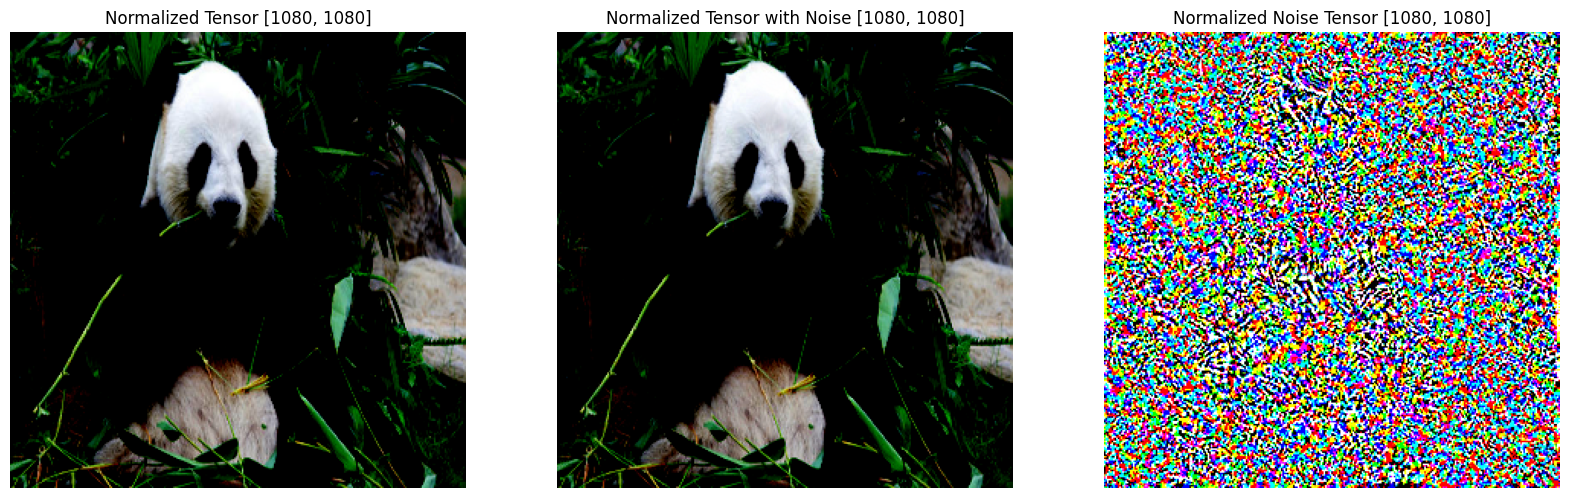

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

im1 = axes[0].imshow(pp.preprocess(image_array)[0])
axes[0].set_title('Normalized Tensor [1080, 1080]')
axes[0].axis('off')

im2 = axes[1].imshow(attacker.noise_generator.apply_noise(pp.preprocess(image_array), noise)[0])
axes[1].set_title('Normalized Tensor with Noise [1080, 1080]')
axes[1].axis('off')


normalized_noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))
im3 = axes[2].imshow(normalized_noise[0])
axes[2].set_title('Normalized Noise Tensor [1080, 1080]')
axes[2].axis('off')

plt.show()
